In [460]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
import seaborn as sns
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from run_test import get_dV_df, compute_unadj_pvals
from stats_tools.as_toolbox import std_to_prob
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')


In [461]:
data_dir = join(base_dir, 'data')
data_long_dir = join(data_dir, 't1_longitudinal')

In [462]:
pred_df = pd.read_feather(join(data_long_dir, 'results', 'volume_prediction_results.feather'))
pred_df.InstanceCreationDate = pd.to_datetime(pred_df.InstanceCreationDate, format='%Y-%m-%d')
with open(join(data_long_dir, 'final', 'affected_brain_regions_dic.pkl'), 'rb') as f:
    affected_br_dic = pickle.load(f)
brain_regions_ls = [item for sublist in list(affected_br_dic.values()) for item in sublist]
with open(join(data_long_dir, 'final', 'long_sids_pairs.pkl'), 'rb') as f:
    long_sids_pairs = pickle.load(f)
with open(join(data_long_dir, 'final', 'cc_dic_ps_optmatch_const10.pkl'), 'rb') as f:
    cc_dic_ps10 = pickle.load(f)

In [464]:
df_dV = get_dV_df(brain_regions_ls, long_sids_pairs, cc_dic_ps10, pred_df)
df_dV.head(3)

,PatientID,Date_diff,Right_Central_Operculum,Left_Central_Operculum,Right_Anterior_Insula,Right_Posterior_Insula,Left_Anterior_Insula,Left_Posterior_Insula,Right_Hippocampus,Left_Hippocampus,...,Right_Temporal_Pole,Left_Temporal_Pole,Right_Anterior_Orbital_Gyrus,Right_Lateral_Orbital_Gyrus,Right_Medial_Orbital_Gyrus,Right_Posterior_Orbital_Gyrus,Left_Anterior_Orbital_Gyrus,Left_Lateral_Orbital_Gyrus,Left_Medial_Orbital_Gyrus,Left_Posterior_Orbital_Gyrus
0,00e520dd9e4c7f2b7798263bd0916221,101,0.124988,0.034193,0.054111,-0.334287,0.093935,0.092807,0.412025,-0.243538,...,-0.544165,-0.438485,-0.353982,0.079901,0.014829,0.100974,-0.355466,-0.544583,0.095302,0.332710
1,00fa9b0bcf1d122b848d9ac4b52c9e40,213,0.252917,0.170099,-0.155423,0.139785,0.033017,0.076063,-0.111458,-0.072630,...,-0.370000,-0.051034,-0.177066,-0.133335,0.153542,-0.354688,-0.117621,-0.160430,0.282845,0.185857
2,02ef1afb3ae8de0e82a5b78fc3b73163,189,0.099196,0.038676,0.111402,-0.041562,0.131057,0.136172,0.117708,0.012765,...,-0.107745,-0.201195,-0.230634,0.002506,-0.042915,0.100810,-0.121000,-0.154462,0.004808,-0.027749


<AxesSubplot:xlabel='Date_diff', ylabel='Count'>

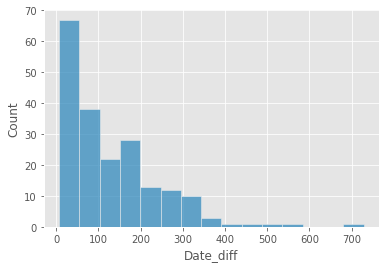

In [465]:
sns.histplot(df_dV.Date_diff)

## Visualize differences

Text(0.5, 1.0, 'All included patients')

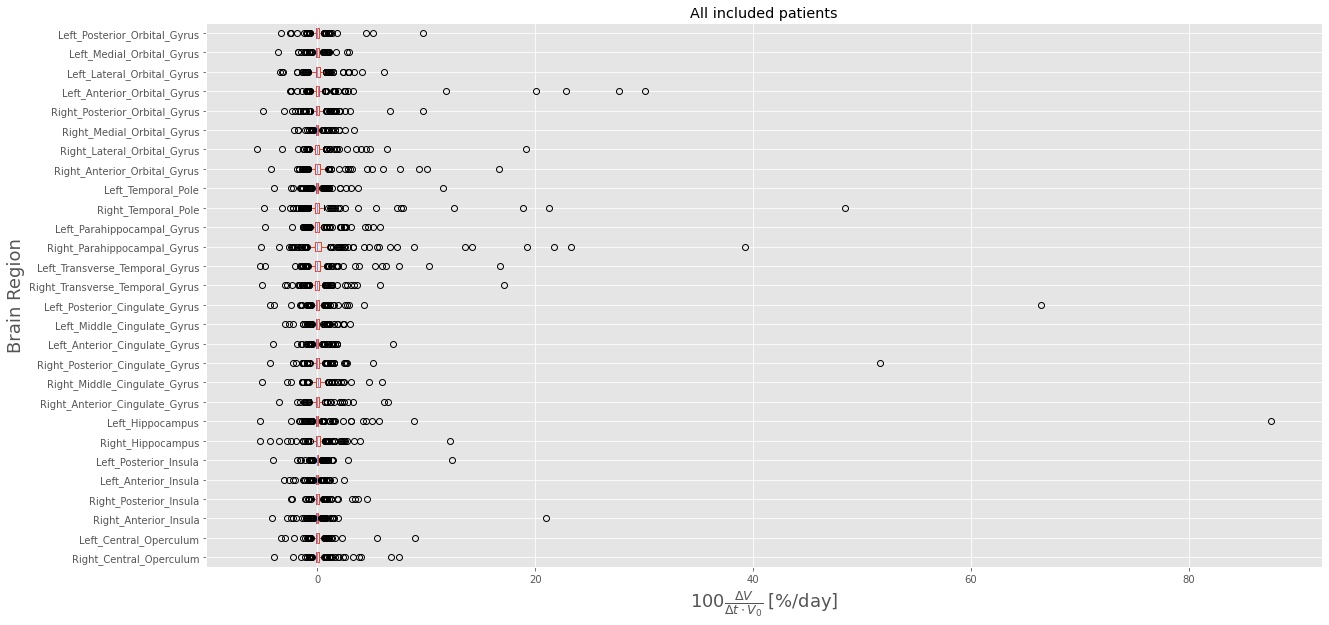

In [466]:
fig, ax = plt.subplots(figsize=(20,10))
plt.style.use('ggplot')
#_ = df_dV[brain_regions_ls].plot(kind='box',ax=ax, orientation='vertical')
df_dV[brain_regions_ls].boxplot(vert=False,ax=ax)
ax.set_ylabel('Brain Region', fontsize=18)
ax.set_xlabel(r'$100\frac{\Delta V}{\Delta t\cdot V_0}\:[\%/{\mathrm{day}}]$', fontsize=18)
#sns.histplot(df_diff, x='Right_Central_Operculum')
ax.set_title('All included patients')

<AxesSubplot:xlabel='Right_Parahippocampal_Gyrus', ylabel='Count'>

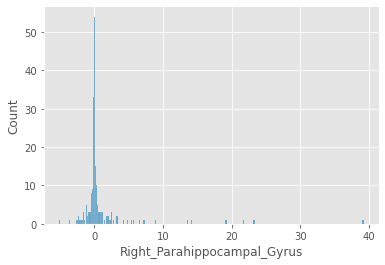

In [467]:
sns.histplot(df_dV.Right_Parahippocampal_Gyrus)

In [469]:
#pval_dic = compute_unadj_pvals(df_dV, cc_dic_ps10, brain_regions_ls)
#pval_dic

{'Right_Central_Operculum': 0.27173494168996526,
 'Left_Central_Operculum': 0.05450889328202235,
 'Right_Anterior_Insula': 0.2970597865149812,
 'Right_Posterior_Insula': 0.0009648057726658887,
 'Left_Anterior_Insula': 0.20514633329922605,
 'Left_Posterior_Insula': 0.08788351941504013,
 'Right_Hippocampus': 0.44730596123729405,
 'Left_Hippocampus': 0.20514633329922605,
 'Right_Anterior_Cingulate_Gyrus': 0.20514633329922605,
 'Right_Middle_Cingulate_Gyrus': 0.12281299384450661,
 'Right_Posterior_Cingulate_Gyrus': 0.1859624380178101,
 'Left_Anterior_Cingulate_Gyrus': 0.11009648434295105,
 'Left_Middle_Cingulate_Gyrus': 0.3524727453601255,
 'Left_Posterior_Cingulate_Gyrus': 0.07825552864928176,
 'Right_Transverse_Temporal_Gyrus': 0.003375011520096005,
 'Left_Transverse_Temporal_Gyrus': 0.20514633329922605,
 'Right_Parahippocampal_Gyrus': 0.3524727453601255,
 'Left_Parahippocampal_Gyrus': 0.3524727453601255,
 'Right_Temporal_Pole': 0.1859624380178101,
 'Left_Temporal_Pole': 0.15179792223956